In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf


In [ ]:
import os
import numpy as np

In [ ]:
 TRAIN_PATH= '/content/drive/My Drive/5_corridors_train_val_data/train-20200530T092227Z-001/unet_input_pro/'
 #TEST_PATH= '/content/drive/My Drive/test_final_traffic/'

In [ ]:
 train_ids = next(os.walk(TRAIN_PATH))[1]
 #test_ids = next(os.walk(TEST_PATH))[1]

In [ ]:
len(train_ids)

317

In [ ]:
# train_ids.remove('.ipynb_checkpoints')
# train_ids

In [ ]:
import numpy as np
import random
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt


In [ ]:
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3

In [ ]:
X_train = np.zeros((len(train_ids)*11, IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(train_ids)*11,IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool)


In [ ]:
print(X_train.shape)
print(Y_train.shape)


(3487, 128, 128, 3)
(3487, 128, 128, 1)


In [ ]:
for root,dirs,filenames in os.walk('/content/drive/My Drive/5_corridors_train_val_data/train-20200530T092227Z-001/unet_input_pro/2_Ave_13/aug'):
  print(filenames)
img_list=[]
mask_list=[]
for item in filenames:
  if item[0]=='i':
    img_list.append(item)
  else:
    mask_list.append(item)
print(len(img_list))
print(len(mask_list))

['image_0_2946167.png', 'mask_0_3439903.png', 'image_0_3439903.png', 'mask_0_2946167.png', 'image_0_9604486.png', 'mask_0_9604486.png', 'image_0_3585337.png', 'mask_0_3585337.png', 'image_0_950159.png', 'mask_0_950159.png', 'image_0_6123244.png', 'mask_0_6123244.png', 'image_0_1225608.png', 'image_0_4272795.png', 'mask_0_4272795.png', 'mask_0_1225608.png', 'image_0_8711928.png', 'mask_0_8711928.png', 'image_0_1719712.png', 'mask_0_4905216.png', 'image_0_4905216.png', 'mask_0_1719712.png']
11
11


In [ ]:

#resize for training
n=0
k=0
for id_ in train_ids:
  path = TRAIN_PATH + id_
  for image_name in img_list:
    img = imread(path + '/aug/' +image_name)[:,:,:IMG_CHANNELS]
    img = resize(img,(IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True)
    X_train[n] = img
    n=n+1
  
  for mask_file in mask_list:
    mask = np.zeros((IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool)
    mask_= imread(path + '/aug/' + mask_file)
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT,IMG_WIDTH),mode='constant',preserve_range=True),axis=-1)
    mask = np.maximum(mask,mask_)
    Y_train[k] = mask
    k=k+1

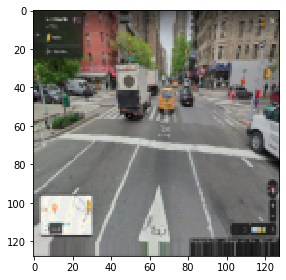

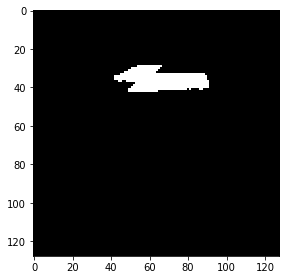

In [ ]:
image_x = random.randint(0,len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [ ]:
inputs= tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

In [ ]:
s=tf.keras.layers.Lambda(lambda x:x / 255)(inputs)

In [ ]:
c1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)

In [ ]:
c1=tf.keras.layers.Dropout(0.1)(c1)

In [ ]:
c1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)

In [ ]:
p1= tf.keras.layers.MaxPooling2D((2,2))(c1)

In [ ]:
c2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2=tf.keras.layers.Dropout(0.1)(c2)
c2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2= tf.keras.layers.MaxPooling2D((2,2))(c2)

In [ ]:
c3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3=tf.keras.layers.Dropout(0.2)(c3)
c3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3= tf.keras.layers.MaxPooling2D((2,2))(c3)

In [ ]:
c4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4=tf.keras.layers.Dropout(0.2)(c4)
c4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4= tf.keras.layers.MaxPooling2D((2,2))(c4)

In [ ]:
c5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5=tf.keras.layers.Dropout(0.3)(c5)
c5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)

In [ ]:
#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu', kernel_initializer='he_normal',padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu', kernel_initializer='he_normal',padding='same')(c6) 

In [ ]:
u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu', kernel_initializer='he_normal',padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu', kernel_initializer='he_normal',padding='same')(c7) 

In [ ]:
u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal',padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal',padding='same')(c8) 

In [ ]:
u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal',padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal',padding='same')(c9) 

In [ ]:
outputs = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)

In [ ]:
model = tf.keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_19[0][0]                  
____________________________________________________________________________________________

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_crosswalk.h5',verbose=1, save_best_only=True)
callbacks = [
             tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_train,Y_train,validation_split=0.1,batch_size=1,epochs=25,callbacks=callbacks)
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

Epoch 1/25
3138/3138 [==============================] - 72s 23ms/step - loss: 0.3321 - accuracy: 0.8896 - val_loss: 0.2132 - val_accuracy: 0.9410
Epoch 2/25
3138/3138 [==============================] - 73s 23ms/step - loss: 0.2745 - accuracy: 0.8963 - val_loss: 0.1915 - val_accuracy: 0.9394
Epoch 3/25
3138/3138 [==============================] - 73s 23ms/step - loss: 0.2460 - accuracy: 0.9046 - val_loss: 0.1851 - val_accuracy: 0.9409
Epoch 4/25
3138/3138 [==============================] - 71s 23ms/step - loss: 0.2265 - accuracy: 0.9101 - val_loss: 0.1662 - val_accuracy: 0.9389
Epoch 5/25
 890/3138 [=======>......................] - ETA: 49s - loss: 0.2103 - accuracy: 0.9152

In [ ]:
from keras.models import load_model

model.save('/content/drive/My Drive/Colab Notebooks/my_model_crosswalk(28june)678(1).h5')  # creates a HDF5 file 'my_model.h5'


on perticular outputs 

In [ ]:
# idx = 211
# print(idx)
# preds_train = model.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)
# preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)
# #preds_test = model.predict(X_test,verbose=1)
# print(preds_train[2].shape)
# print(Y_train[2].shape)
# preds_train_t = (preds_train>0.3).astype(np.uint8)
# preds_val_t = (preds_val > 0.3).astype(np.uint8)
# #preds_test_t = (preds_test > 0.2).astype(np.uint8)


# ix = random.randint(0,len(preds_train_t))
# imshow(X_train[ix])
# plt.show()
# imshow(np.squeeze(Y_train[ix]))
# plt.show()
# imshow(np.squeeze(preds_train_t[ix]))
# plt.show()


# ix = random.randint(0,len(preds_val_t))
# print(ix)
# imshow(X_train[int(X_train.shape[0]*0.9):][ix])
# plt.show()
# imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
# plt.show()
# imshow(np.squeeze(preds_val_t[ix]))
# plt.show()

loading pretrained model

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import load_model
# model = load_model('/content/drive/My Drive/Colab Notebooks/my_model_crosswalk(27june).h5')

In [ ]:
idx = random.randint(0, len(X_train))
print(idx)
preds_train = model.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)
#preds_test = model.predict(X_test,verbose=1)
print(preds_train[2].shape)
print(Y_train[2].shape)
preds_train_t = (preds_train>0.3).astype(np.uint8)
preds_val_t = (preds_val > 0.3).astype(np.uint8)
#preds_test_t = (preds_test > 0.2).astype(np.uint8)


ix = random.randint(0,len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()


ix = random.randint(0,len(preds_val_t))
print(ix)
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [ ]:
print(Y_train[ix].shape)

In [ ]:
print(preds_train_t[ix].shape)

In [ ]:
n = preds_train_t[ix]

In [ ]:
m = Y_train[ix]


In [ ]:
type(m[120][122][0])

In [ ]:
new_Y_train = m.astype(int)

bool to int because preds_train_t[ix] is int therefore we changed Y_train[ix]
 which was having values as TRUe or False into int 

In [ ]:
type(new_Y_train)

In [ ]:
m = list(new_Y_train)
n = list(n)

createn flatten list of true values

In [ ]:
flat_true = []
for x in m:
  flat_true.append(list(x))


In [ ]:
flat_list_true = []
flat_list_true1 = []
for sublist in flat_true:
  type(sublist)
  for item in sublist:
    flat_list_true.append(item)
# print(set(flat_list_true))  
for i in flat_list_true:
  flat_list_true1.append(list(i))   

In [ ]:
flat_list_truef = []
for sublist in flat_list_true1:
  type(sublist)
  for item in sublist:
    flat_list_truef.append(item)

In [ ]:
set(flat_list_truef)

same code for predictions 

In [ ]:
flat_pred = []
for x in n:
  flat_pred.append(list(x))


In [ ]:
flat_list_pred = []
flat_list_pred1 = []
for sublist in flat_pred:
  type(sublist)
  for item in sublist:
    flat_list_pred.append(item)
# print(set(flat_list_true))  
for i in flat_list_pred:
  flat_list_pred1.append(list(i))   

In [ ]:
flat_list_predf = []
for sublist in flat_list_pred1:
  type(sublist)
  for item in sublist:
    flat_list_predf.append(item)

In [ ]:
set(flat_list_predf)

checking shape

In [ ]:
len(flat_list_truef),len(flat_list_predf)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(flat_list_truef, flat_list_predf)
cm

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
import itertools
cm_plot_labels = ['background','crosswalk']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')